In [4]:
import numpy as np
from skfem import *
from skfem.supermeshing import intersect, elementwise_quadrature
from skfem.models.elasticity import (linear_elasticity, lame_parameters,
                                     linear_stress)
from skfem.helpers import dot, sym_grad, jump, mul
from skfem.io.json import from_file
from pathlib import Path
import pandas as pd 
import skfem as fem
import json 
import matplotlib.pyplot as plt 

from skfem.visuals.matplotlib import plot, draw




ValueError: Boundary 'contact' not found.

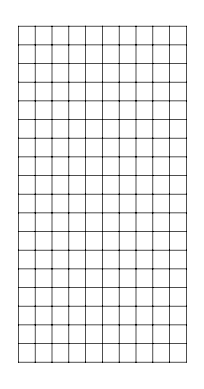

In [8]:
mesh_file = Path('ex04_mesh.json')
m1 = from_file(mesh_file)

m2 = ((MeshLine(np.linspace(1,2,6)))*MeshLine(np.linspace(-1,1,10))).refined().with_boundaries({'contact': lambda x:x[0]==1.0,'dirichlet':lambda x: x[0]== 2.0})


draw(m2)
#definiere Netze 
e1 = ElementVector(ElementTriP2())
e2 = ElementVector(ElementQuad2())

#spanne Blueprint netze über unsere Netze 
m1t, orig1 = m1.trace('contact', mtype=MeshLine, project=lambda p: p[1:])
m2t, orig2 = m2.trace('contact', mtype=MeshLine, project=lambda p: p[1:])



#create supermesh for integration

m12, t1, t2 = intersect(m1t, m2t)

bases = [ 
         Basis(m1, e1),
         Basis(m2, e2)]

fbases = [ 
          FacetBasis(m1,e1,quadrature=elementwise_quadrature(m1t,m12,t1),
                     facets=orig1[t1]),
          FacetBasis(m2, e2,
                     quadrature=elementwise_quadrature(m2t,m12,t2),
                     facets=orig2[t2]),
]



#problem definition 

youngs_modulus = 1000.0
poisson_ratio   =0.7
poisson_ratio   =0.7


weakform = linear_elasticity(*lame_parameters(youngs_modulus, poisson_ratio)) # 
C = linear_stress(*lame_parameters(youngs_modulus, poisson_ratio))

alpha = 1000
limit = 0.3


@BilinearForm
def bilin_mortar(u,v,w):
     ju, jv = jump(w, dot(u, w.n), dot(v, w.n))
     mu = .5 * dot(w.n, mul(C(sym_grad(u)), w.n))
     mv = .5 * dot(w.n, mul(C(sym_grad(v)), w.n))
     return ((1. / (alpha*w.h)* ju * jv -mu * jv -mv *ju)*(np.abs(w.x[1])<= limit))

def gap(x): 
     return ( 1. - np.sqrt(1. - x[1]**2))


@LinearForm 
def lin_mortar(v, w):   
     jv = jump(w, dot(v,w.n))
     mv = .5 *dot(w.n,mul(C(sym_grad(v)),w.n))
     return ((1. / (alpha*w.h)*gap(w.x)*jv - gap(w.x)*mv)
             *(np.abs(w.x[1])<=limit))
     

params = {
     'h': fbases[1].mesh_parameters(),
     'n': -fbases[1].normals,

}
A = asm(weakform, bases, to=list)
B = asm(bilin_mortar, fbases, fbases, **params,to=list)
b= asm(lin_mortar,fbases,**params,to=list)

K = bmat([[A[0] + B[0], B[2]],
          [B[1], A[1]+ B[3]]], 'csr')

f = np.concatenate(b)

D1 = bases[0].get_dofs('dirichlet').all()
D2 = bases[1].get_dofs('dirichlet').all() + K.blocks[0]

#Randbedingungen

y1 = bases[0].zeros()
y2 = bases[1].zeros()
y1[bases[0].get_dofs('dirichlet').all('u^1')] = .1
y = np.concatenate((y1, y2))

#linear solve  dofs == degrees of Freedom 

y= solve(*condense(K,f,D=np.concatenate((D1,D2)),x=y))



#create a displaced mesh for visualization 

sf = 1

y1,y2 = np.split(y,K.blocks)

mdefo1 = m1.translated(sf * y1[bases[0].nodal_dofs])
mdefo2 = m2.translated(sf * y2[bases[1].nodal_dofs])


#calculate von mises stress

s1, s2 = {},{}
dg1 = bases[0].with_element(ElementTriDG(ElementTriP1()))
dg2 = bases[1].with_element(ElementQuadDG(ElementQuad1()))
u1 = bases[0].interpolate(y1)
u2 = bases[1].interpolate(y2)

for i in [0,1]:
     for j in [0,1]: 
          s1[i,j] = dg1.project(C(sym_grad(u1))[i, j])
          s2[i,j] = dg2.project(C(sym_grad(u2))[i,j])
          
s1[2,2] = poisson_ratio * (s1[0,0]+ s1[1,1])
s2[2,2] = poisson_ratio * (s2[0,0] + s2[1,1])

vonmises1 = np.sqrt(.5 * ((s1[0, 0] - s1[1, 1]) ** 2 +
                          (s1[1, 1] - s1[2, 2]) ** 2 +
                          (s1[2, 2] - s1[0, 0]) ** 2 +
                          6. * s1[0, 1] ** 2))

vonmises2 = np.sqrt(.5 * ((s2[0, 0] - s2[1, 1]) ** 2 +
                          (s2[1, 1] - s2[2, 2]) ** 2 +
                          (s2[2, 2] - s2[0, 0]) ** 2 +
                          6. * s2[0, 1] ** 2))


def visualize():
     from skfem.visuals.matplotlib import plot, draw
     pdg1 = Basis(mdefo1, dg1.elem)
     pdg2 = Basis(mdefo2, dg2.elem)
     ax = plot(pdg1, vonmises1, shading='gouraud',colorbar=r"$\sigma_{\mathrm{mises}}$")
     draw(mdefo1, ax=ax)
     plot(pdg2, vonmises2, ax=ax, nrefs=3, shadin='gouraud')
     draw(mdefo2, ax=ax)
     return ax

visualize().show()

In [1]:
m2 = ((MeshLine(np.linspace(1,2,6)))*MeshLine(np.linspace(-1,1,10))).refined().with_boundaries({'contact': lambda x:x[0]==1.0,'dirichlet':lambda x: x[0]== 2.0})


print(m2)
print(type(m2))

NameError: name 'MeshLine' is not defined